# Experiment Design Lecture 2A: Response Surface Methodology

Link: [http://charlesreid1.com/wiki/Response_Surface_Methodology](http://charlesreid1.com/wiki/Response_Surface_Methodology)

## Overview

A brief overview of response surface methodology (RSM) was given in [Lecture 1](ED_1_Introduction.ipynb), so let's review that again.

RSM is a set of methods for fitting a polynomial to a multi-input, multi-output function,

$$
Y = f(X)
$$

using a surrogate function to approximate:

$$
\hat{Y} = g(X)
$$

### Why Polynomials?

We learn in introdutory calculus that Maclaurin and Taylor series expansions are capable of representing any suitably well-behaved function in a suitably small neighborhood by expressing it in terms of an infinite sum of powers of x with coefficients.

Often, complicated functions are simplified (e.g., for integration or evaluation) by writing a Taylor series expansion, which is just a polynomial, and truncating all but a finite (hopefully few) terms.

### Why Not Polynomials?

Some care is required to select a system response vector $Y$ that lends itself well to being modeled with a polynomial. Rapidly-changing or overly-sensitive quantities can make $f(X)$ simply too complicated to model using a polynomial.

Another risk is in extrapolating outside of the experimental region: the fitted polynomial only describes responses in a smooth manner over the region where data were obtained.

Outside of this region, the polynomial values can quickly become spurious or non-physical. 

Let's return to the Taylor series for $\sin{x}$ from the first lecture. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy
from sympy.functions import sin as sympy_sin

from pprint import pprint
from scipy.special import factorial

In [2]:
def f(x):
    """Real function"""
    return np.sin(x)

def g(x):
    """Surrogate function from Taylor series about x=0,
    sin(x) ~ x - 1/3! x^3 + 1/5! x^5
    """
    x0 = 0
    dx = x - x0
    dim = np.shape(dx)[0]
    result = np.zeros(dim,)
    for i in range(dim):
        dxi = dx[i]
        val = dxi
        val -= (1/factorial(3))*pow(dxi,3)
        val += (1/factorial(5))*pow(dxi,5)
        result[i] = val
    
    return result

In [3]:
# Taylor approximation at x0 of function f
def taylor(f,x,x0,n):
    """Function f should be a sympy function.
    """
    i = 0
    p = 0
    while i <= n:
        p = p + (f.diff(x,i).subs(x,x0))/(factorial(i))*(x-x0)**i
        i += 1
    return p

In [4]:
def g_alt(x, n=5):
    """Taylor series
    """
    xv = sympy.Symbol('x')
    f = sympy_sin(xv)
    
    x0 = 0
    dim = np.shape(x)[0]
    
    r = taylor(f,xv,x0,n)
    
    result = np.zeros(dim,)
    
    for i in range(dim):
        result[i] = r.evalf(n=15, subs={xv: x[i]})
    
    return result

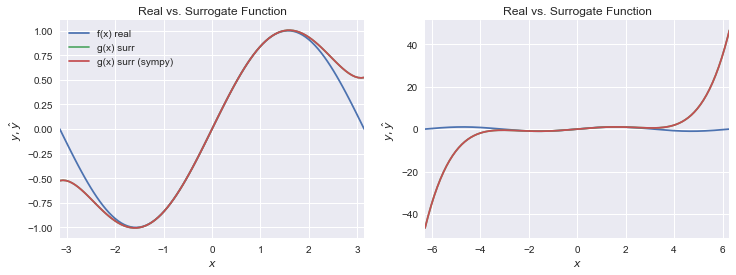

In [5]:
the_x = np.linspace(-np.pi,np.pi,100)
big_x = np.linspace(-2*np.pi,2*np.pi,200)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

for x, ax in zip([the_x,big_x], [ax1,ax2]):
    ax.plot(x, f(x), label='f(x) real')
    ax.plot(x, g(x), label='g(x) surr')
    ax.plot(x, g_alt(x), label='g(x) surr (sympy)')
    
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y, \hat{y}$')
    ax.set_xlim([min(x), max(x)])
    ax.set_title('Real vs. Surrogate Function')

ax1.legend()
plt.show()

This surrogate function is only applicable in the neighbohood of $x=0$, so the further we get, the worse the approximation gets.

### Other Types of Linear Models

Are there other ways of using linear models besides RSM? Indeed there are. This is testament to the fact that linear models are surprisingly powerful, given their simplicity.

Here is a partial list of techniques that build linear models of sytem resopnses:

**Generalized Linear Models (GLM)** - These linear models can account for an arbitrary number of inputs and outputs. GLM models postulate that the error in the model representation $y - \hat{y}$ is Gaussian normal. Statistical techniques are then used to construct a linear model and associated error estimates.

**Multiple Linear Regression** - Linear regression technique used to construct models for a *single* response variable $y$ and multiple predictor variables $X$. 

**Multivariate Linear Regression** - Extending multiple linear regression to the case of a multivariate response vector $Y$ is called multivariate linear regression.

**Polynomial Models (Univariate)** - In the simple case of a univariate input and univariate output, the system function $y = f(x)$ can be fit using a simple polynomial fitting procedure.

**Response Surface Models (Multivariate)** - We will cover this in more detail below.

# Strategy for Comprehensive Regression Analysis

Selecting a strategy for comprehensive regression analysis requires some care and consideration of the specifics of your system.

A proposal following the validation strategy in the NISS paper

Steps 1-3 provide information going into the surrogate model construction process

* Determine important variables (prior steps)
* Specify a model form
* Design experiments to determine function samples
* Define selection criteria and comparison metrics
* Calculate comparison metrics, plot data
* Assess if the model is good enough, assess model assumptions, select if satisfied (otherwise proceed to next step)
* Specify a new model form (that can incorporate already-gathered information!) and repeat until criteria met

# Selecting a Model

In order to select the model that is best for the indented use, two things must be done:

First, figure out what is wanted out of the model (the selection criteria).

Second, figure out how to select the model that is the best for that criteria (the comparison metrics).

Part of the difficulty in defining goals and selection criteria is that multivariate surfaces are very difficult to visualize in higher than 2 dimensions. Various selection criteria, i.e. numerical quantities related to error, curvature, best fit, etc., should be used to determine which surface is the best for the intended use. 

## Pre-Selection Step: Experimental Design

Selecting the form of the surrogate model means selecting the experimental design you plan to use. The experimental design will give a set of experiments (inputs) to run to best regress a black box function to some particular functional form (e.g., a polynomial). Assuming a particular funtional form allows the number of experiments/samples to be minimized.

If a Monte Carlo simulation is being run, the cost is higher (thousands or millions more function samples are needed), but the method is very flexible - any model may be selected and its parameters fit to the data.

For more information on the experimental design step, see the Experimental Design Lecture. 

## Selection Criteria

The most obvious criteria is minimization of the model's representation error,

$$
\min_{X} Y(X) - \hat{Y}(X)
$$

where $X$ is the input parameter vector, $Y$ is the system response vector, and $\hat{Y}$ is the surrogate model representation of the real response vector.

What experimental design is trying to accomplish for simulations and experiments is similar:

* Experiments are trying to create a simple and cheap model that can adequately represent the relevant features of a relevant physical system
* Simulations are trying to create a simple and cheap model that can adequately represent the result of a much more expensive and complicated model

However, the end use is often different:

* Simulations are trying to determine values of input parameters that lead to the best match between models and experiments
* Experiments are trying to create models that can be used to optimize or control a process, or find minimum/maximum points

### Least Squares for Linear Regression

Linear regression models a response $Y$ as a linear function of $N$ input variables $X$:

$$
Y_i = \beta_0 + \sum_{i=0}^{N} \beta_i + \epsilon_i
$$

Using least squares for a linear regression model approximates the coefficients of the linear model by minimizing the sum of the squared error residuals (SSE),

$$
\mbox{SS}_{E} = \sum r_i^2 = \sum \left( y_i - \hat{y} \right)^2
$$

The estimated coefficients that meet this criteria are then called least squares coefficient estimates.

To do this, the SSE equation above is differentiated with respect to each of the parameters $b_0, b_1, b_2, \dots$

All these derivatives are set equal to 0, and these equations are solved simultaneously. In practice, this is done using matrix algebra, which is typically wrapped with a high-level API in a computational implementation.

### Linear Regression with Scikit-Learn

We can use `scikit-learn` to do basic linear regression:

In [6]:
from sklearn import linear_model

In [ ]:
def noisy_line(x):
    m = 4
    b = 1
    return m*x + b + 2*np.random.randn(*np.shape(x))

def noisy_line_model(x,y):
    lr = linear_model.LinearRegression()
    lr.fit(x,y)
    return lr

def noisy_line_fit(x,y):
    lr = noisy_line_model(x,y)
    return lr.predict(x)

In [ ]:
N = 30
x = np.linspace(0,5,N).reshape(-1,1)
y = noisy_line(x)
yhat = noisy_line_fit(x,y)

#print(yhat.shape)
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(x,yhat,'g:',label='fit')
ax.plot(x,y,'go',label='data')

ax.legend()
plt.show()

In [ ]:
#print(help(linear_model.LinearRegression))

In [ ]:
m = noisy_line_model(x,y)

print("\nR^2 = %0.4f"%(m.score(x,y)))
print("\nCoefficient vector = %s"%(m.coef_))

### Interpretation

Cannot necessarily interpret approximated coefficients as "amount of change in $\hat{y}$ for a unit change in $x_j$"... This assumes that the coefficients are completely independent

In order to determine how good this assumption is, regress the input/predictor variable $x_j$ on all other variables (i.e. find $x_j$ as a function of all other input/predictor variables + constant)

The residuals from this fit are $r^{\star} = x_{ij} - \hat{x}_{ij}$

The coefficient estimate $b_j$ measures the change in the response due to a unit change in $r^{\star}$, not in $x_{ij}$.

If $x_j$ can't be predicted by other variables, then $r^{\star} \approx x_{ij} - \overline{x}_{ij}$ (where overline = average value)

In this case, $b_j$ can be interpreted in the way specified: i.e. measure of change in $\hat{y}$ for unit change in $x_j$.

### Significance

Coefficients cannot be used by themselves to determine relative significance of various terms in the linear model

To actually do this, you need to use normalized/weighted coefficients $\hat{\beta}_j$

Defined as:

$$
\hat{\beta}_j = b_j \left( \frac{s_{jj}}{s_{yy}} \right)^2
$$

where

$$
s_{jj} = \dfrac{ \sum (x_{ij} - \overline{x}_j)^2 }{ (n-1) } \\
s_{yy} = \dfrac{ \sum (y_i - \overline{y}_i)^2 }{ (n-1) }
$$

The overline indicates a sample mean.